In [1]:
import numpy as np
from Music_Style_Transfer_master.project.midi_handler import score2midi
from Music_Style_Transfer_master.project.utils import get_representation, dataset_import
from Music_Style_Transfer_master.project.model_transformer_relative import _2way_transformer_wavenet_absolute_pitch, _2way_transformer_wavenet_relative_pitch

import tqdm
import pypianoroll as pr
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

# 33:97 A1~C7  21:109 A0~C8
# 7 octave 21:105  A0~G#7  
def midi2score(path, beat_resolution, pitch_range=np.arange(21, 109)):
    tmp = pr.Multitrack(filename=path, beat_resolution=beat_resolution)   
    tmp.binarize()
    tmp.assign_constant(1)
    # TODO: use variable to handle pitch range
    score = tmp.get_merged_pianoroll()[:, pitch_range]
    
    return score

def load_model(path_model):
    model = _2way_transformer_wavenet_absolute_pitch(len_context = 8*4*beat_resolution,
                                                 n_octave = 7,
                                                 size_embedding = 84,
                                                 n_transf_layers = 4,
                                                 n_transf_downsample = 0,
                                                 n_conv_layers = 7,
                                                 context_layers = 1)
    model.load_weights(path_model)
    
    return model

def time_index_chosing(_range,
                       interval,
                       random=True,
                       time_list=None):
    # For parallel generation
    
    interval += 1
    if (random):
        time_index_base = np.random.randint(_range)
    else:
        time_index_base = time_list[np.random.randint(len(time_list))]

    c = time_index_base + np.arange(-interval * 200, interval * 200, interval)

    return c[np.where(np.logical_and(c >= 0, c < _range))]


def generation(model, score, meta, time_indexes, midi_indexes,
                       len_context
                       ):
    time_indexes = np.array(time_indexes) +  len_context
    
    left_features = (np.array(score[[np.arange(t -  len_context, t) for t in time_indexes], :]) > 0).astype(int)
    left_metas = np.array(meta[[np.arange(t -  len_context, t) for t in time_indexes], :])
    
    right_features = (np.array(score[[np.arange(t + 1, t + 1 + len_context) for t in time_indexes], :]) > 0).astype(int)
    right_metas = np.array(meta[[np.arange(t + 1, t + 1 + len_context) for t in time_indexes], :])
    
    central_features = (np.array(score[time_indexes, :]) > 0).astype(int)
    central_metas = np.array(meta[time_indexes, :])
    
    for a, b in enumerate(midi_indexes):
        central_features[a, b:] = 2
        
    central_features = np.reshape(central_features, (len(time_indexes), 1, -1))
    central_metas = np.reshape(central_metas, (len(time_indexes), 1, -1))

    p = model.predict([left_features,  left_metas, 
                       central_features, central_metas,
                       right_features, right_metas])
    
    return p

def style_transfer(score, meta, score_melody, model, len_context, pitch_range, 
                   iter_num=25, threshold=0.5
                   ):

    fixed_rhythm_score = score_melody
    original_len = len(score_melody)
    new_score = np.array(score)
    counter = 0
    alpha_initial = 0.6
    alpha = alpha_initial
    alpha_min = 0
    annealing_fraction = 0.6
    update_count = 0
    
    plt.figure(figsize=(20, 20))
    plt.imshow(new_score[len_context:-len_context, :pitch_range].T)
    plt.pause(1)
    
    for i in tqdm.tqdm(range(iter_num)):
        time_list = np.arange(original_len)
        if i < iter_num*0.9:
            score[len_context:-len_context] = np.logical_or(score[len_context:-len_context], score_melody).astype(int)
        print("alpha = ", alpha)
        
        while (time_list.size > 0):
            if(alpha != -1):
                alpha = max(0, alpha_initial - update_count * (alpha_initial - alpha_min) / (
                    iter_num * original_len * annealing_fraction))
            if(alpha == 0):
                score = new_score
                alpha = -1
            elif(counter / original_len > alpha and alpha != -1):
                counter = 0
                score = np.array(new_score)

            time_indexes = time_index_chosing(original_len, len_context, random=False, time_list=time_list)
            l = len(time_indexes)
            sorter = np.argsort(time_list)
            d = sorter[np.searchsorted(time_list, time_indexes, sorter=sorter)]
            time_list = np.delete(time_list, d, 0)
            counter += l

            update_count += l

            if(alpha != -1):
                midi_indexes = np.arange(pitch_range).tolist() * len(time_indexes)
                time_indexes_repeat = np.repeat(time_indexes, pitch_range)
                p = generation(model, score, meta, time_indexes_repeat, midi_indexes, len_context)
                
                # TODO: This for loop seems can be removed
                for j, t in enumerate(time_indexes_repeat):
                    update = p[0][j]
                    if update < threshold :
                        new_score[t + len_context, midi_indexes[j]] = 0
                    else:
                        new_score[t + len_context, midi_indexes[j]] = 1
               
            else:
                for midi_index in range(pitch_range):
                    
                    midi_indexes = [midi_index] * l
                    p = generation(model, score, meta, time_indexes, midi_indexes, len_context)
                        
                    for j, t in enumerate(time_indexes):
                        update = p[0][j]
                        if i > (0.8 *iter_num):
                            if(fixed_rhythm_score[t, midi_indexes[j]] == 0):
                                if update < threshold :
                                    new_score[t + len_context, midi_indexes[j]] = 0
                                else:
                                    new_score[t + len_context, midi_indexes[j]] = 1
                        else:   
                            if update <threshold :
                                new_score[t + len_context, midi_indexes[j]] = 0
                            else:
                                new_score[t + len_context, midi_indexes[j]] = 1
        # For plotting
        plt.figure(figsize=(20, 20))
        plt.imshow(new_score[len_context:-len_context, :pitch_range].T)
        plt.pause(1)
    return new_score[len_context:-len_context, :pitch_range]

Using TensorFlow backend.


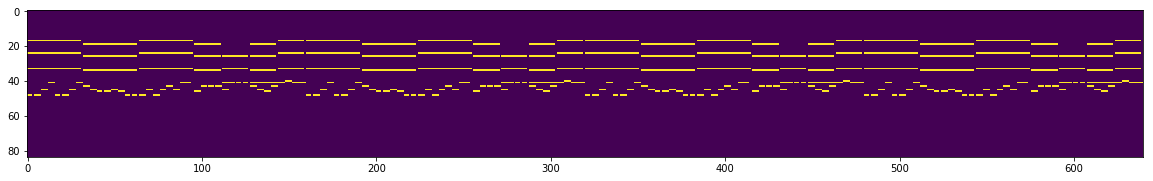


  0%|          | 0/10 [00:00<?, ?it/s]

alpha =  0.6


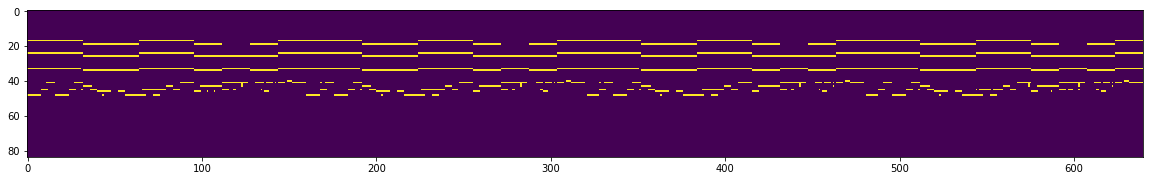


 10%|█         | 1/10 [02:36<23:26, 156.25s/it]

alpha =  0.5003124999999999


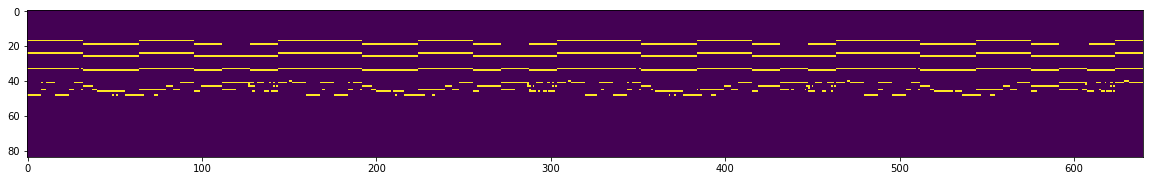


 20%|██        | 2/10 [05:01<20:23, 152.89s/it]

alpha =  0.40031249999999996


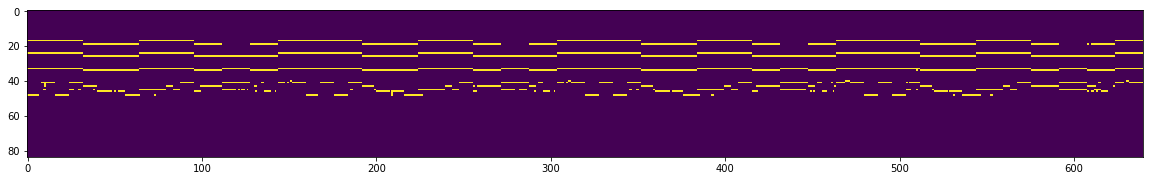


 30%|███       | 3/10 [07:27<17:35, 150.83s/it]

alpha =  0.3003125


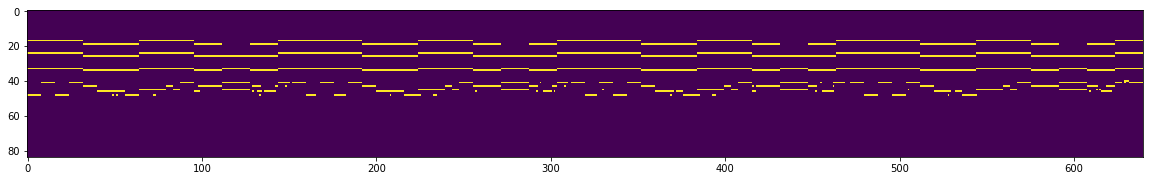


 40%|████      | 4/10 [09:53<14:56, 149.35s/it]

alpha =  0.2003125


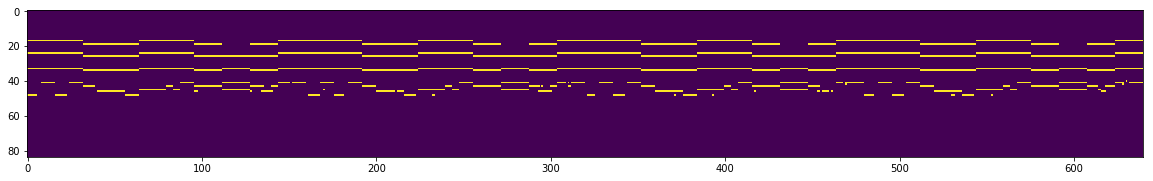


 50%|█████     | 5/10 [12:18<12:20, 148.03s/it]

alpha =  0.10031249999999997


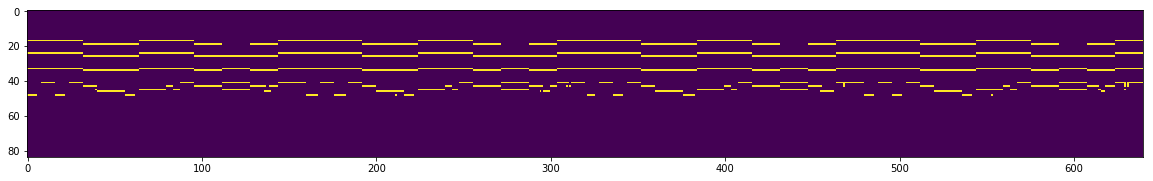


 60%|██████    | 6/10 [14:43<09:49, 147.32s/it]

alpha =  0.00031250000000004885


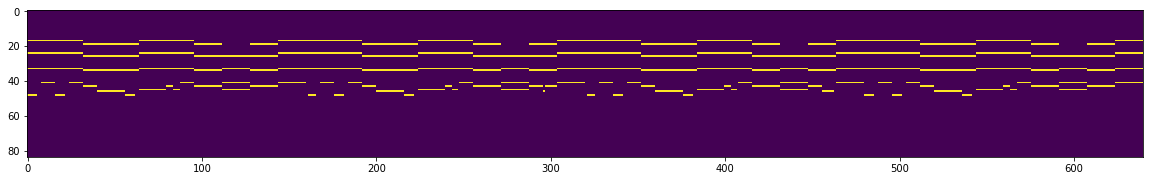


 70%|███████   | 7/10 [28:09<17:14, 344.84s/it]

alpha =  -1


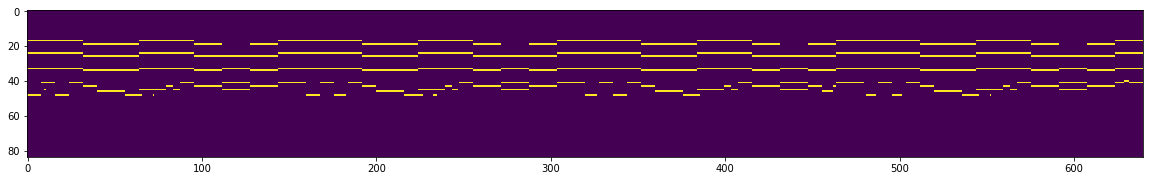


 80%|████████  | 8/10 [41:29<16:02, 481.48s/it]

alpha =  -1


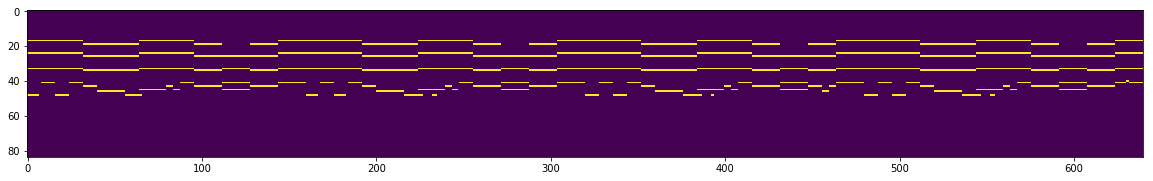


 90%|█████████ | 9/10 [54:53<09:38, 578.06s/it]

alpha =  -1


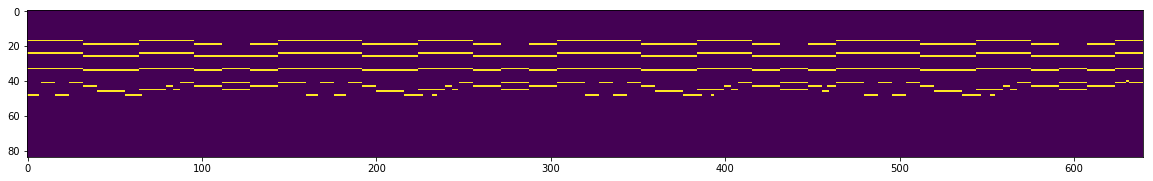


100%|██████████| 10/10 [1:08:12<00:00, 644.34s/it]

In [9]:
beat_resolution = 8
pitch_range = 84
len_context = beat_resolution*4*8
max_len = beat_resolution*4*4

path_model = "../../../scratch/wtl272/projects/Music_style_transfer/runs/run_61/model/model.hdf5"

# load model
model = load_model(path_model)

path = "input_midi/0716/train_harmonized.mid"
path_melody = "input_midi/0716/train.mid"

score = midi2score(path, beat_resolution, pitch_range=np.arange(21, 105))

if path_melody is None:
    score_melody = np.zeros(score.shape)
else:
    score_melody = midi2score(path_melody, beat_resolution, pitch_range=np.arange(21, 105))
 
score = np.array(score[:640])
score_melody = np.array(score_melody[:640])
score, score_meta = get_representation(score, pitch_range, beat_resolution, len_context)

#generation
result = style_transfer((np.array(score[:, :, 2]) > 0).astype(int), score_meta, 
                         score_melody, model, len_context, pitch_range, iter_num=15)

#save result
score2midi("output_midi/train_bah_model61.mid", result[:len(score_melody)], beat_resolution, 
           120, pitch_range=np.arange(21, 105),melody_constraint=True, melody=score_melody)